In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import time
import datetime

from sklearn.base import TransformerMixin
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Imputer

import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

import warnings
warnings.filterwarnings('ignore')
# Currently getting warning : 
# label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. 
# Returning False, but in future this will result in an error. Use 'array.size > 0' to check that 
# an array is not empty.
#
# ... which was apparently fixed pre sklearn 0.19.1 but didn't make it into the build, suppressing for now...

%matplotlib inline

# Load the data
train_df = pd.read_csv('data/train.csv', header=0)
test_df = pd.read_csv('data/test.csv', header=0)

CV_FOLDS = 10
SCORER = make_scorer(accuracy_score)
# standard value for unknowns/nan/nulls
UNKNOWN_VALUE = "XX"
LABEL_COL = 'Survived'
ID_COL = 'PassengerId'


# Exploratory code

### Correlations

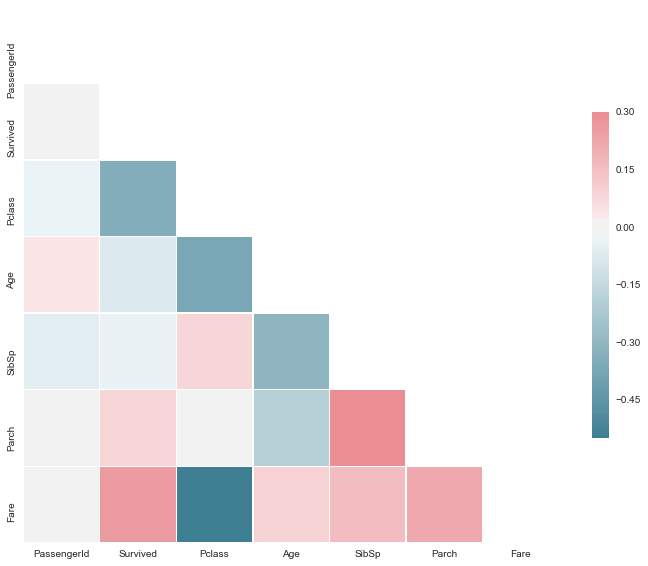

In [2]:
# Correlations among features and between features/label

corr = train_df.corr()

# # save to csv
# corr.to_csv("titanic_corr.csv")

# as a raw matrix
# corr

#
# plot correlations using seaborn heatmap
#
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
sns.set(style="white")
cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, 
            cbar_kws={"shrink": .5})

## Distributions

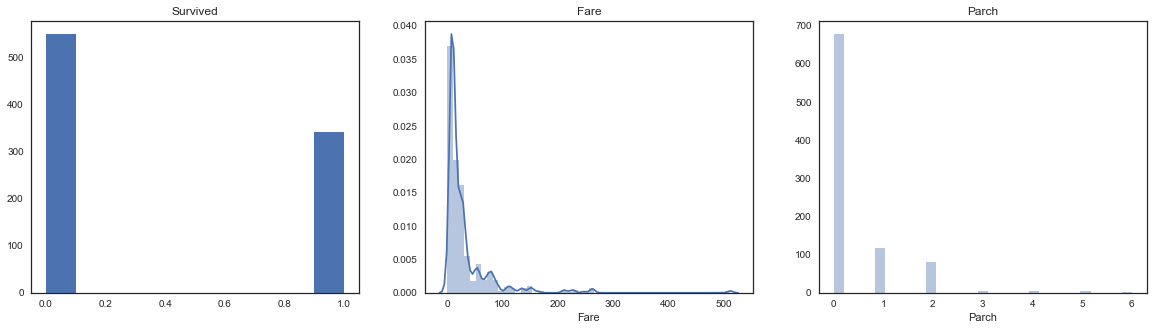

In [3]:
per_row = 3
fig, axs = plt.subplots(figsize=(20, 5), ncols=per_row) 

# Label is only in the train data
axs[0].set_title(LABEL_COL)
axs[0].hist(train_df[LABEL_COL])
plot_count = 1

# Histos of all data among cols of your choosing
for col in ['Fare', 'Parch']:
    row_item_count = plot_count % per_row
    
    if (row_item_count == 0):
        fig, axs = plt.subplots(figsize=(20, 5), ncols=per_row) 
        
    axs[row_item_count].set_title(col)

    # Plot numerics as distribs...
    if col in ['Fare']:
        sns.distplot(train_df[col], ax=axs[row_item_count])
    # .. categs as histos
    else:
        sns.distplot(train_df[col], ax=axs[row_item_count], kde=False)
    
    plot_count = plot_count + 1

### Distribs by label value

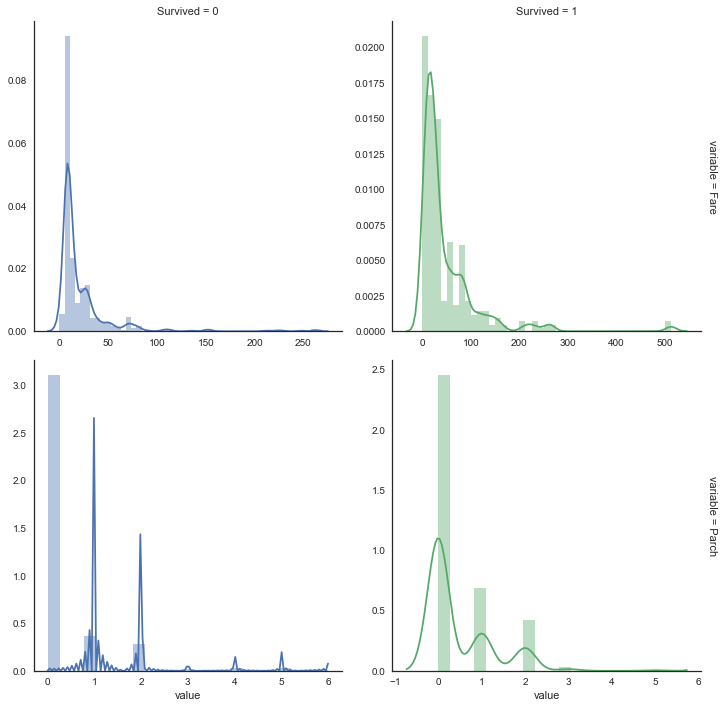

In [4]:
# have to melt the dataset and use the variable name as the 'row' var in the FacetGrid
# there will be a different graph pair per variable and each pair is split on the 'col' var (the label)
train_df_melted = train_df.melt(id_vars=[LABEL_COL], value_vars=['Fare', 'Parch'])

g = sns.FacetGrid(train_df_melted, 
                  col=LABEL_COL, 
                  hue=LABEL_COL, 
                  row='variable', 
                  sharex=False, 
                  sharey=False, 
                  margin_titles=True,
                  size = 5)

g = g.map(sns.distplot, 'value')

## New/Derived Features

In [5]:
#
# UDF to extract just the name prefix (Mr., Ms. , etc)
#
def get_prefix(input_string):
    first_period_index = str.index(input_string, ".")
    prev_space_index = input_string.rfind(" ", 0, first_period_index-1)
    return input_string[prev_space_index+1:first_period_index+1]

#
# Extract the first part of the ticket code where applicable
#
def get_ticket_code(ticket):
    if (ticket != "" and not pd.isnull(ticket)):        
        ticket_split = ticket.split(" ")
        if len(ticket_split) == 1:
            return UNKNOWN_VALUE
        else:
            return ticket_split[0].strip().replace(".","").replace("/","").lower()
    else:
        return UNKNOWN_VALUE

# Cols which will be used as features directly (Fare) or indirectly (Name -> prefix)
#
# Note that we don't keep 'Age', it made no diff on the LB (for me anyway...)
#
cols_to_keep = ['Fare', 'SibSp', 'Parch', 'Pclass', 'Sex', 'Embarked', 'Name', 'Ticket']

# Use test and train together to ensure we see all possible values
train_and_test_X = train_df.append(test_df)
train_and_test_X = train_and_test_X.reset_index()

# Finally subset to only usable cols before moving on
train_and_test_X = train_and_test_X[cols_to_keep]

In [6]:
# Sample Names
train_and_test_X.head(5)['Name']

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [7]:
# Sample Ticket Codes
train_and_test_X.head(5)['Ticket']

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [8]:
#
# Extract new features
#
train_and_test_X['Prefix'] = train_and_test_X['Name'].apply(get_prefix)
train_and_test_X['TicketCode'] = train_and_test_X['Ticket'].apply(get_ticket_code)

# Overall Family Size (or, how many are traveling with) = Parch + SibSp
train_and_test_X['FamilySize'] = train_and_test_X[['Parch', 'SibSp']].apply(lambda r : r[0] + r[1], axis=1)

# Separate numerics anc categoricals for later analysis
numeric_cols = ['Fare', 'FamilySize', 'Pclass']
categorical_cols = ['Sex', 'Prefix', 'Embarked', 'TicketCode']

# Subset to cols we'll use as features
train_and_test_X = train_and_test_X[numeric_cols + categorical_cols]

### Imputation

In [9]:
#
# Impute a particular column grouping by another column
# Fill in with median if numeric, most common value otherwise
#
class ContextualImputer(TransformerMixin):
    
    # constructor params:
    #  col : col to impute
    #  byCol : column within which to impute 'col'
    def __init__(self, col, byCol):
        self.col = col
        self.byCol = byCol
    
    # 
    # Use median/most common for numeris/categoricals but do it within the context of another col
    #
    def fit(self, X, y=None):
        self.bycolumn_unique_values = np.unique(X[self.byCol].values)
        
        if X[self.col].dtype != np.dtype('O'):
            bycolumn_fill_values = [np.median((X[pd.notnull(X[self.col]) & (X[self.byCol] == bycolumn_unique_value_obj)][self.col])) 
                                  for bycolumn_unique_value_obj in self.bycolumn_unique_values]
        else:
            bycolumn_fill_values = [X[pd.notnull(X[self.col]) & (X[self.byCol] == bycolumn_unique_value)][self.col].value_counts().index[0]  
                                  for bycolumn_unique_value in self.bycolumn_unique_values]

        bycolumn_values_fill_zipped = np.column_stack((self.bycolumn_unique_values, bycolumn_fill_values))
        self.bycolumn_values_fill_zipped_dict = dict(bycolumn_values_fill_zipped)
        
        return self

    def transform(self, X, y=None):
        def fill(row):
            if pd.isnull(row[self.col]):
                return self.bycolumn_values_fill_zipped_dict[row[self.byCol]]
            else:
                return row[self.col]

        X[self.col] = X[self.col].fillna(X.apply(fill, axis=1))
        return X

# Custom imputation for Fare by Class
# Was useful for Age too (by Prefix), but I ended up not using Age
all_X_imputed = ContextualImputer('Fare', 'Pclass').fit_transform(train_and_test_X)

# Only two missing values and other features most resembled the 'C' group
all_X_imputed['Embarked'] = np.where(train_and_test_X['Embarked'].isnull(), 
                                     'C', train_and_test_X['Embarked'])

### Analysis of categoricals
#### Take a look at the distribution by label, Y axis is percentage with label = 1

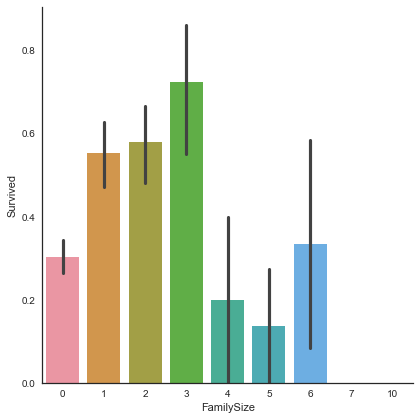

In [10]:
# Concat training X and Y values
train_with_label = pd.concat([train_and_test_X[0:train_df.shape[0]], train_df[LABEL_COL]], axis=1)

#
# Family Size and the label are not cleanly correlated as-is
#   so FamilySize wouldn't be the best feature as-is.
#
# However, there are some possible groupings among specific values
#
g = sns.factorplot(x="FamilySize", y=LABEL_COL, data=train_with_label, kind="bar", size = 6)

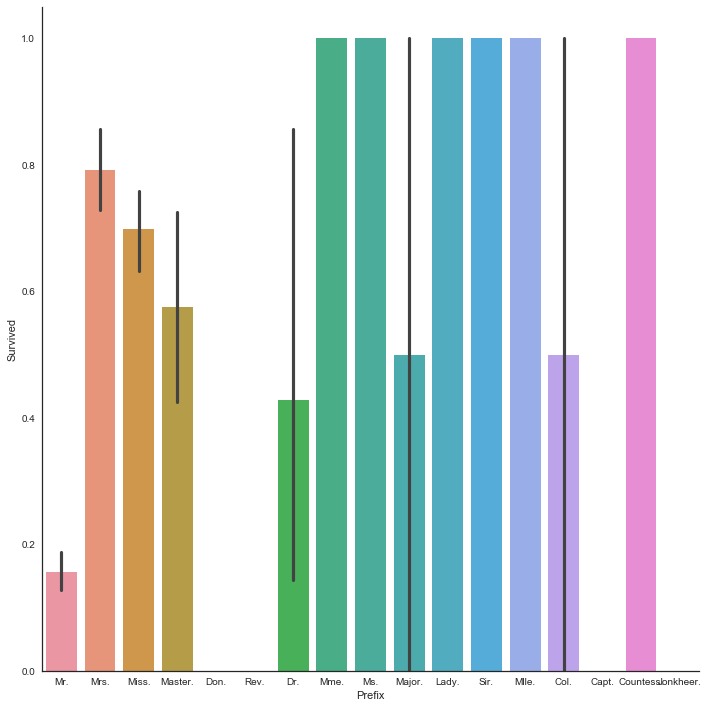

In [13]:
g = sns.factorplot(x="Prefix", y=LABEL_COL, data=train_with_label, kind="bar", size = 10)

### Encoding

#### Simple one-hot encoding and conversion to numbers

In [14]:
all_X_encoded = all_X_imputed

#
# Onehot encoding of cateogricals using get_dummies
#
# Although Pclass is a number, it's really a code and we'll treat it as such
#
for categorical_col in ['Pclass', 'Embarked', 'Sex']:
    all_X_encoded = pd.concat([pd.get_dummies(all_X_imputed[categorical_col], 
                                              prefix=categorical_col, 
                                              drop_first=True), 
                               all_X_encoded], axis=1)

### Encoding by 'binning' according to graph above
#### Note that we're applying to train and test data 

In [15]:
# FamilySize
#
all_X_encoded["FamilySize_0"] = all_X_encoded["FamilySize"].map(lambda s: 1 if s == 0 else 0)
all_X_encoded["FamilySize_12"] = all_X_encoded["FamilySize"].map(lambda s: 1 if (s == 1 or s == 2) else 0)
all_X_encoded["FamilySize_3"] = all_X_encoded["FamilySize"].map(lambda s: 1 if (s == 3) else 0)
all_X_encoded["FamilySize_gt3"] = all_X_encoded["FamilySize"].map(lambda s: 1 if s > 3 else 0)

# Prefix.  
#
high_prob = ['Mme.', 'Ms.', 'Lady.', 'Sir.', 'Mlle.', 'Countess']
medhigh_prob = ['Mrs.', 'Miss.']
med_prob = ['Dr.', 'Major.', 'Col.']
low_prob = ['Mr.']
very_low_prob = ['Capt.', 'Don.', 'Rev.', 'Jonkheer.']
known_probs = high_prob + med_prob + low_prob + very_low_prob

all_X_encoded["Prefix_high"] = all_X_encoded["Prefix"].map(lambda s: 1 if s in high_prob else 0)
all_X_encoded["Prefix_medhigh_prob"] = all_X_encoded["Prefix"].map(lambda s: 1 if s in medhigh_prob else 0)
all_X_encoded["Prefix_med"] = all_X_encoded["Prefix"].map(lambda s: 1 if s in med_prob else 0)
all_X_encoded["Prefix_low"] = all_X_encoded["Prefix"].map(lambda s: 1 if s in low_prob else 0)
all_X_encoded["Prefix_very_low"] = all_X_encoded["Prefix"].map(lambda s: 1 if s in very_low_prob else 0)

# TicketCode
#
high_prob = ['swpp', 'sc']
med_high_prob = ['pc', 'pp', 'fcc', 'scah']
med_prob = ['stono2', 'XX', 'ca', 'scparis', 'stono', 'c', 'ppp']
low_prob = ['a5', 'soc', 'wc', 'sotonoq', 'wep']
very_low_prob = ['sca4', 'a4', 'sp', 'spo', 'fa', 'scow', 'as', 'sopp', 'fc', 'sotono2', 'casoton']
known_probs = high_prob + med_high_prob + med_prob + low_prob + very_low_prob 

all_X_encoded["TicketCode_high"] = all_X_encoded["TicketCode"].map(lambda s: 1 if s in high_prob else 0)
all_X_encoded["TicketCode_medhigh"] = all_X_encoded["TicketCode"].map(lambda s: 1 if s in med_high_prob else 0)
all_X_encoded["TicketCode_med"] = all_X_encoded["TicketCode"].map(lambda s: 1 if s in med_prob else 0)
all_X_encoded["TicketCode_low"] = all_X_encoded["TicketCode"].map(lambda s: 1 if s in low_prob else 0)
all_X_encoded["TicketCode_very_low"] = all_X_encoded["TicketCode"].map(lambda s: 1 if s in very_low_prob else 0)

#### Wrap up, drop cols we don't need and separate out 

In [16]:
all_X_final = all_X_encoded

all_X_final.drop("Prefix", inplace=True, axis=1)
all_X_final.drop("TicketCode", inplace=True, axis=1)
all_X_final.drop("Embarked", inplace=True, axis=1)
all_X_final.drop("Pclass", inplace=True, axis=1)
all_X_final.drop("FamilySize", inplace=True, axis=1)
all_X_final.drop("Sex", inplace=True, axis=1)

test_X = all_X_final[all_X_final.shape[0]-test_df.shape[0]::]

In [17]:
# What we're left with

all_X_final.head(5)

,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Fare,FamilySize_0,FamilySize_12,FamilySize_3,FamilySize_gt3,Prefix_high,Prefix_medhigh_prob,Prefix_med,Prefix_low,Prefix_very_low,TicketCode_high,TicketCode_medhigh,TicketCode_med,TicketCode_low,TicketCode_very_low
0,1,0,1,0,1,7.2500,0,1,0,0,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,71.2833,0,1,0,0,0,1,0,0,0,0,1,0,0,0
2,0,0,1,0,1,7.9250,1,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0,0,1,0,0,53.1000,0,1,0,0,0,1,0,0,0,0,0,1,0,0
4,1,0,1,0,1,8.0500,1,0,0,0,0,0,0,1,0,0,0,1,0,0


## Run a handful of individual classifiers....

#### XGBoost

In [18]:
start_time = time.time()

parameters = {
    'learning_rate': [.1],
    'max_depth': [3],
    'n_estimators': [100],
    'reg_alpha':[.75],
    'reg_lambda':[.75]
}

grid_obj = GridSearchCV(xgb.XGBClassifier(), 
                        parameters, 
                        scoring=SCORER, 
                        cv=CV_FOLDS, 
                        verbose=1, 
                        n_jobs=4)

xgbc_best = grid_obj.fit(all_X_final[0:train_df.shape[0]], train_df[LABEL_COL]).best_estimator_

print("CV : best estimator accuracy : {0}".format(grid_obj.best_score_))
print("CV : best estimator range (.95) : {0} - {1}".format(grid_obj.best_score_ - 2*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_], grid_obj.best_score_ + 2*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_]))
print("\nCV : xgbc_best : {0}".format(xgbc_best))

print("\nXGBoost : CV elapsed time : {0}".format((time.time() - start_time)))
print("Last run time : {0}".format(datetime.datetime.now()))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.3s finished


CV : best estimator accuracy : 0.8395061728395061
CV : best estimator range (.95) : 0.782311257005874 - 0.8967010886731382

CV : xgbc_best : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.75, reg_lambda=0.75, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

XGBoost : CV elapsed time : 0.462939977645874
Last run time : 2018-07-02 19:39:09.473208


#### SVM

In [19]:
start_time = time.time()

parameters = {
    'kernel': ['rbf'],
    'max_iter' : [10000],
    'gamma': [.01],
    'C': [4]
}

grid_obj = GridSearchCV(SVC(probability=True), 
                        parameters, 
                        scoring=SCORER, 
                        cv=CV_FOLDS, 
                        verbose=1,
                        n_jobs=4)
svc_best = grid_obj.fit(all_X_final[0:train_df.shape[0]], train_df[LABEL_COL]).best_estimator_

print("best estimator accuracy : {0}".format(grid_obj.best_score_))
print("best estimator range (.95) : {0} - {1}".format(grid_obj.best_score_ - 2*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_], grid_obj.best_score_ + 2*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_]))
print("\nsvc_best : {0}".format(svc_best))

print("elapsed time : {0}".format((time.time() - start_time)))
print("Last run time : {0}".format(datetime.datetime.now()))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s


best estimator accuracy : 0.792368125701459
best estimator range (.95) : 0.7469638242704925 - 0.8377724271324255

svc_best : SVC(C=4, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=10000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
elapsed time : 0.7211461067199707
Last run time : 2018-07-02 19:39:11.916745


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.5s finished


### ExtraTreesCassifier
#### Similar to RF but randomized decision boundaries can reduce variance

In [20]:
from sklearn.ensemble import ExtraTreesClassifier
start_time = time.time()

parameters = {
    "max_depth": [5],
    "max_features": [7],
    "min_samples_leaf": [4],
    "min_samples_split": [5],
    "n_estimators" :[100]
}

# Run the grid search over cv split data
grid_obj = GridSearchCV(ExtraTreesClassifier(), 
                        parameters, 
                        scoring=SCORER, 
                        cv=CV_FOLDS, 
                        verbose=1,
                        n_jobs=4)

# best combination of parameters
etc_best = grid_obj.fit(all_X_final[0:train_df.shape[0]], train_df[LABEL_COL]).best_estimator_

print("best estimator accuracy : {0}".format(grid_obj.best_score_))
print("best estimator range (.95) : {0} - {1}".format(grid_obj.best_score_ - 2*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_], grid_obj.best_score_ + 2*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_]))
print("\nsvc_best : {0}".format(etc_best))

print("elapsed time : {0}".format((time.time() - start_time)))
print("Last run time : {0}".format(datetime.datetime.now()))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Done   3 out of  10 | elapsed:    0.2s remaining:    0.4s


best estimator accuracy : 0.8395061728395061
best estimator range (.95) : 0.7782161275071824 - 0.9007962181718299

svc_best : ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=5, max_features=7, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
elapsed time : 0.8098649978637695
Last run time : 2018-07-02 19:39:14.430015


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.5s finished


### Adaboost

In [21]:
start_time = time.time()

parameters = {
    "base_estimator__criterion" : ["entropy"],
    "base_estimator__splitter" :   ["best"],
    "n_estimators": [10],
    "learning_rate":  [.1],
    "algorithm" : ['SAMME.R']
}

grid_obj = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier()), 
                        parameters, 
                        scoring=SCORER, 
                        cv=CV_FOLDS,
                        verbose=1,
                        n_jobs=4)

ada_best = grid_obj.fit(all_X_final[0:train_df.shape[0]], train_df[LABEL_COL]).best_estimator_
print("best estimator accuracy : {0}".format(grid_obj.best_score_))
print("best estimator range (.95) : {0} - {1}".format(grid_obj.best_score_ - 2*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_], grid_obj.best_score_ + 2*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_]))
print("\nada_best : {0}".format(ada_best))

print("elapsed time : {0}".format((time.time() - start_time)))
print("Last run time : {0}".format(datetime.datetime.now()))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
best estimator accuracy : 0.8338945005611672
best estimator range (.95) : 0.7827940727174426 - 0.8849949284048918

ada_best : AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.1, n_estimators=10, random_state=None)
elapsed time : 0.3175849914550781
Last run time : 2018-07-02 19:39:16.336456


[Parallel(n_jobs=4)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished


### Random Forest

In [22]:
start_time = time.time()

parameters = {
    "max_depth": [5],
    "max_features" : [15],
    "min_samples_split" : [10],
    "n_estimators": [50]
}

grid_obj = GridSearchCV(RandomForestClassifier(), 
                        parameters, 
                        scoring=SCORER, 
                        cv=CV_FOLDS,
                        verbose=1,
                        n_jobs=4)
rf_best = grid_obj.fit(all_X_final[0:train_df.shape[0]], train_df[LABEL_COL]).best_estimator_
print("best estimator accuracy : {0}".format(grid_obj.best_score_))
print("best estimator range (.95) : {0} - {1}".format(grid_obj.best_score_ - 2*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_], grid_obj.best_score_ + 2*grid_obj.cv_results_['std_test_score'][grid_obj.best_index_]))
print("\nrf_best : {0}".format(rf_best))

print("\nelapsed time : {0}".format((time.time() - start_time)))
print("Last run time : {0}".format(datetime.datetime.now()))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s


best estimator accuracy : 0.8327721661054994
best estimator range (.95) : 0.7704919487834475 - 0.8950523834275513

rf_best : RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=15, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

elapsed time : 0.5642070770263672
Last run time : 2018-07-02 19:39:18.342240


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.3s finished


### VotingClassifier

In [23]:
from sklearn.ensemble import VotingClassifier
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

start_time = time.time()

estimators = []
estimators.append(('xgbc_best', xgbc_best))
estimators.append(('ada_best', ada_best))
estimators.append(('svc_best', svc_best))
estimators.append(('rf_best', rf_best))
estimators.append(('etc_best', etc_best))

vc = VotingClassifier(estimators, voting='soft', n_jobs=4)
vc.fit(X=all_X_final[0:train_df.shape[0]], y=train_df[LABEL_COL])

final_predictions = vc.predict(test_X)
final_predictions_df = pd.DataFrame({ID_COL: test_df[ID_COL], LABEL_COL: final_predictions })
final_predictions_df.to_csv("submission_vc.csv", index=False)

print("VotingClassifier : estimators : {0}".format([estimator[0] for estimator in estimators]))
print("elapsed time : {0}".format(time.time() - start_time, [estimator[0] for estimator in estimators]))
print("Last run time : {0}".format(datetime.datetime.now()))

VotingClassifier : estimators : ['xgbc_best', 'ada_best', 'svc_best', 'rf_best', 'etc_best']
elapsed time : 0.3188619613647461
Last run time : 2018-07-02 19:39:19.884181
